In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import io
import seaborn as sns
from random import randint
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
from google.colab import files


# 1 - Um modelo de variáveis discretas

In [48]:
from google.colab import files

## Faça upload de um dataset com nome insurance (baixável em https://www.kaggle.com/mirichoi0218/insurance)
uploaded = files.upload()

Saving insurance.csv to insurance.csv


In [49]:
insu = pd.read_csv('/content/insurance.csv')
insu.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


O objetivo aqui é fazer algum tipo de programa que seja capaz de prever o valor que está escrito em charges a partir das outras característias dadas por instância. Para isso, será necessário uma regressão para obter o valor proposto. Além disso, utilizar-se-á a técnica de clustering para estudar grupos e tentar dividir os pacotes em diferentes classes. Veja que temos 6 features, então tentaremos usar técnicas de PCA para reduzir o número de features necessárias, usar um pouco de DataViz (a ver: onehotencoding)

In [7]:
insu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:
insu.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

São 1338 instâncias, alguns dos elementos são do tipo object, então algum tipo de encoding pode ser interessante. Obviamente, tratam-se de elementos discretos, mas para observar correlação é necessário codificar como número. A célula abaixo transforma as colunas de tipo object para tipo float

In [50]:
Object = insu.columns[insu.dtypes=='object']

for name in Object:
  label = LabelEncoder()
  int_data = label.fit_transform(insu[name])
  int_data = int_data.reshape(len(int_data), 1)
  insu[name] = int_data

insu.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


In [ ]:
insu.describe()

In [24]:
insu.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000


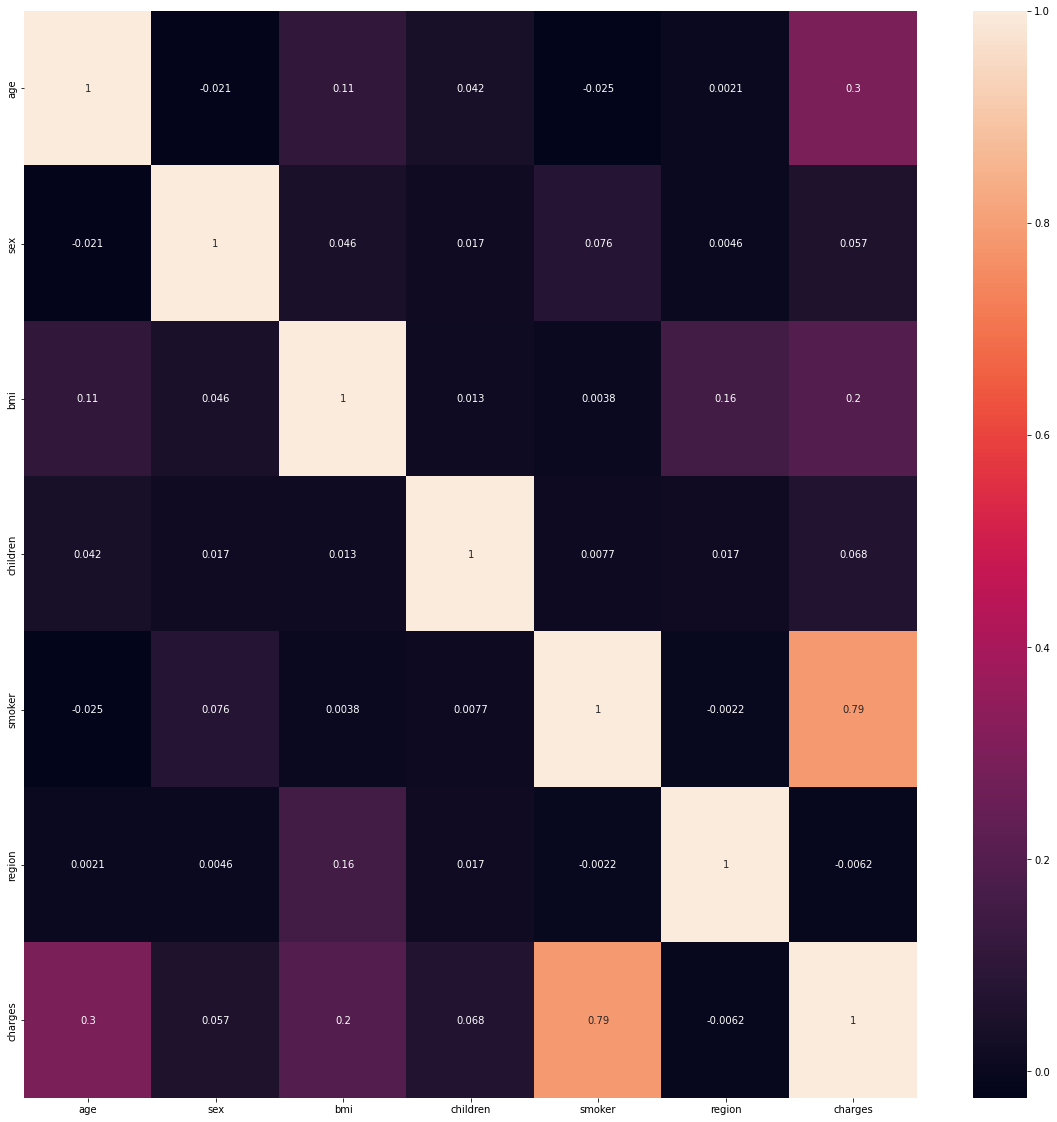

In [25]:
plt.figure(figsize = (20,20))

sns.heatmap(insu.corr(), annot = True)

In [51]:
insu_no_label = insu.drop(['charges'],axis = 1)
insu_no_label.head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1


In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
insu_PCA = pca.fit_transform(insu_no_label)
pca.explained_variance_ratio_

array([0.83285322, 0.15430606])

In [45]:
df = pd.DataFrame(insu_PCA)
df.head()

,0,1
0,-20.336894,-1.541811
1,-20.990680,4.349017
2,-11.045077,3.002313
3,-6.663684,-7.595553
4,-7.302951,-1.375675


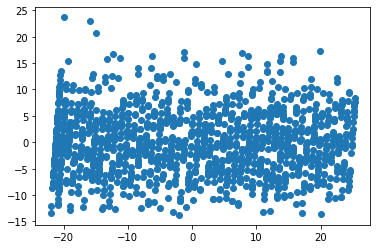

In [47]:
plt.scatter(df[0], df[1])
plt.show()

Vemos que há uma boa variância

Como se pode ver, os primeiros dois principal components correspondem a 97,5% da variância dos dados. Logo, para a sequência pode ser interessante trabalhar apenas com esses dois componentes principais. Abaixo temos o dataframe reconstruído

In [42]:
insu_recovered = pca.inverse_transform(insu_PCA)

insu_recovered = pd.DataFrame(insu_recovered)
insu_recovered.head()

,0,1,2,3,4,5
0,18.994318,0.513095,27.942446,1.017736,0.218555,1.459910
1,17.999188,0.537770,33.782616,1.024106,0.221845,1.635301
2,28.006180,0.525288,33.017070,1.058721,0.214103,1.599924
3,32.996222,0.478658,22.696701,1.059064,0.205897,1.285932
4,31.996456,0.504676,28.866059,1.065977,0.209335,1.471145


O PCA nao parece ser capaz de preservar bem os dados. Isso se deve pois todas as categoras de dados são discretas, e logo o PCA não funciona bem a não ser que os dados sejam codados em one hot (conforme explicado em https://towardsdatascience.com/pca-is-not-feature-selection-3344fb764ae6). Abaixo, no entanto, vemos que os valores médios para todos os parâmetros continuar razoável. (A discutir: alternativa para PCA em dados discretos). Na sequência trabalharemos com um dataset com dados mais contínuos

In [49]:
insu_recovered.describe()

,0,1,2,3,4,5
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,1.515695
std,14.049960,0.026766,6.098099,0.052586,0.010450,0.180759
min,17.995014,0.435493,15.927503,0.993705,0.183088,1.102897
25%,26.994144,0.486725,26.277524,1.047813,0.196165,1.385678
50%,39.009095,0.503680,30.367449,1.095537,0.204579,1.509542
75%,51.001656,0.522920,34.714510,1.139196,0.213958,1.638764
max,64.007696,0.616402,53.123338,1.200612,0.230304,2.212008


## Regressão linear

Para prever os valores das taxas em charges, uma regressão linear com as seis features pode ser executada

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(insu_no_label, insu['charges'])

lin_reg = LinearRegression()
#print(y_train)
lin_reg.fit(X_train, y_train)
lin_reg.score(X_test,y_test)

0.719473467886317

A regressão linear acaba não tendo um resultado tão bom (na média de uns 70%). Isso é até esperado, pois temos 6 features, algumas delas discretas, o que dificulta a tarefa de regressão linear pura. Na sequência tentaremos uma regressão linear com dados contínuos e com PCA para ver se há alguma mudança. Para termos uma noção visual, abaixo temos a linha de regressão linear de charges baseada em bmi (única variável contínua).

In [72]:
lin_reg.fit(insu['bmi'].values, insu['charges'].values)
print(lin_reg.score(X_test.reshape(-1,1),y_test.reshape(-1,1)))


0.0407320971276377


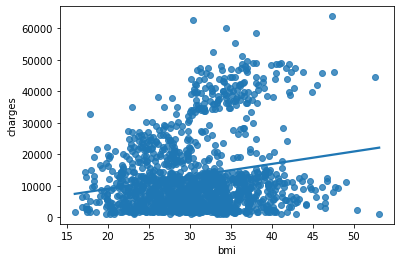

In [75]:
sns.regplot(x = 'bmi',
            y = 'charges', 
            ci = None,
            data = insu)

# 2 - Um modelo de variáveis contínuas

## Análise inicial do Dataset

In [4]:

## Faça upload de um dataset com nome insurance (baixável em https://www.kaggle.com/yasserh/breast-cancer-dataset)
uploaded = files.upload()

reg = pd.read_csv('/content/breast-cancer.csv')
reg.head(10)

Saving breast-cancer.csv to breast-cancer.csv


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [66]:
reg.info()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


Esse dataset é muito melhor. O valores das features são floats, enquanto o target (os labels necessários para um algoritmo de classificação são discretos). Segue que as técnicas anteriores são muito melhor aplicáveis.

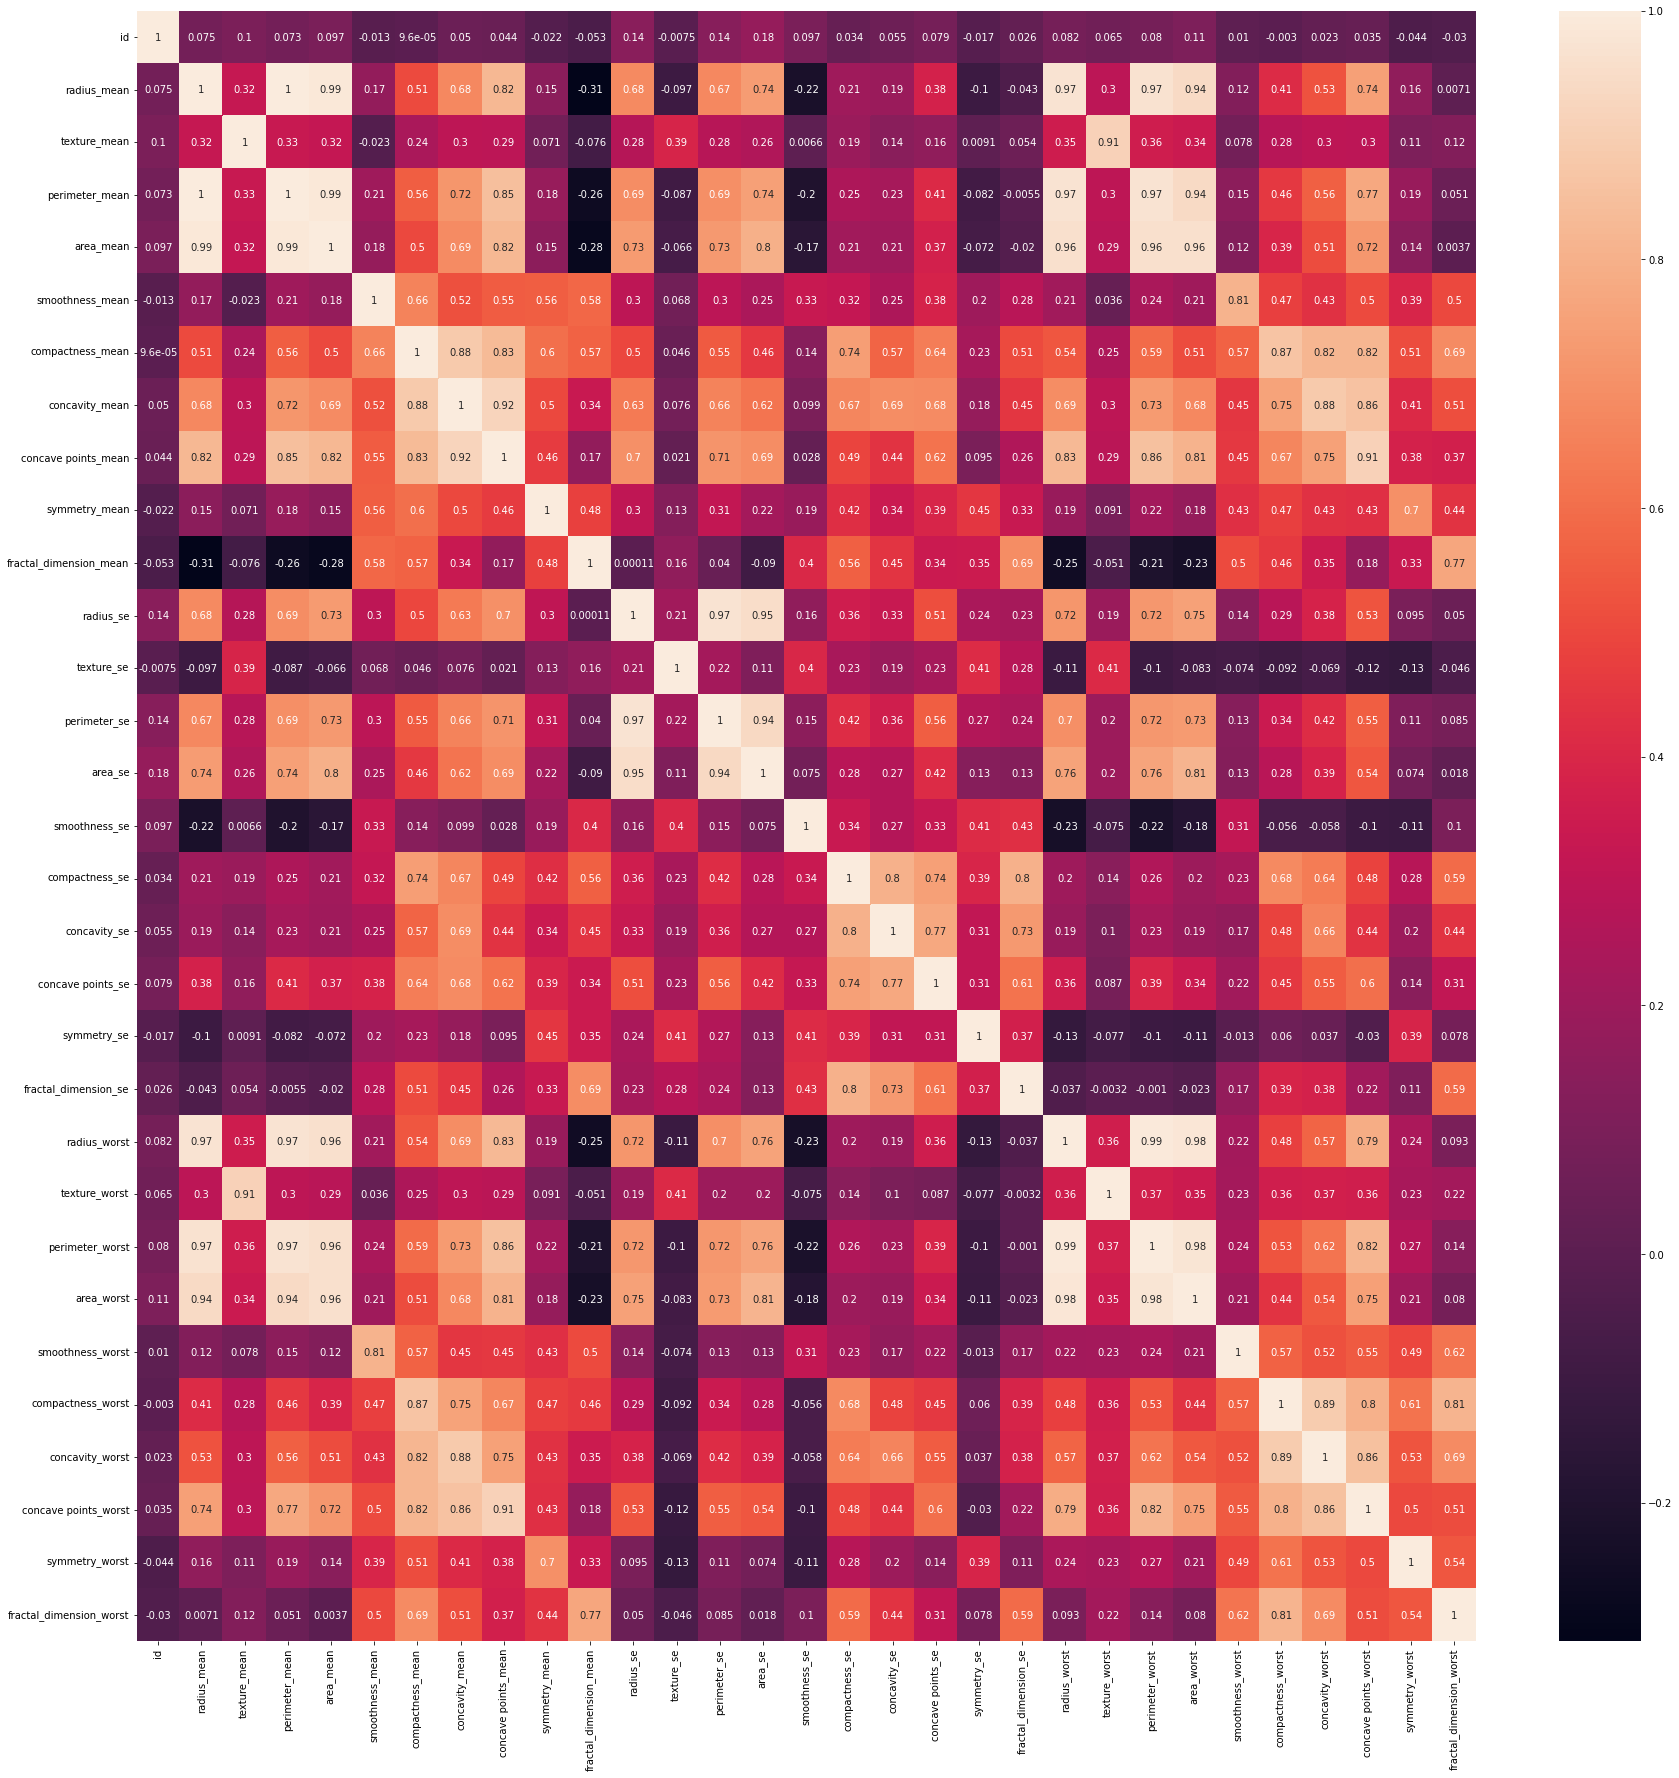

In [55]:
reg.corr()
plt.figure(figsize = (30,30))

sns.heatmap(reg.corr(), annot = True)

In [6]:
reg_no_label = reg.drop(['diagnosis','id'],axis = 1)
reg_no_label.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Outliers

Vamos lidar com outliers antes de fazer qualquer outra análise

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

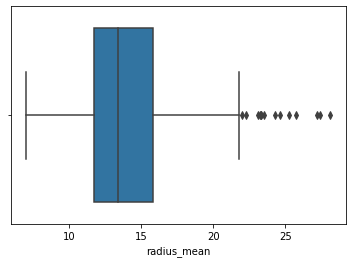

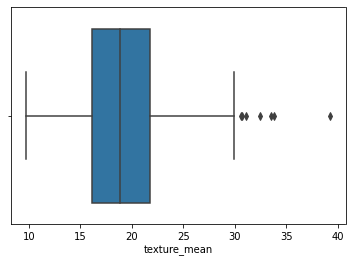

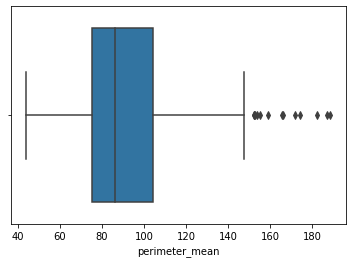

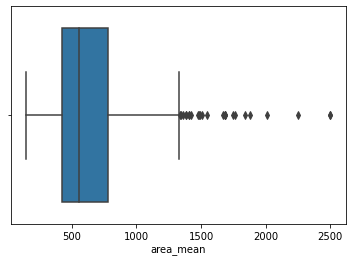

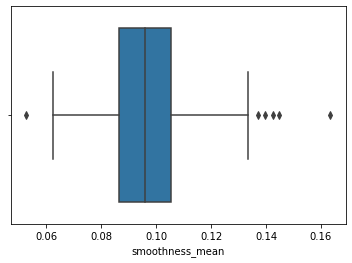

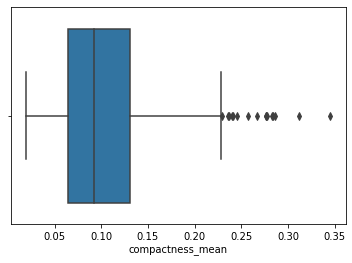

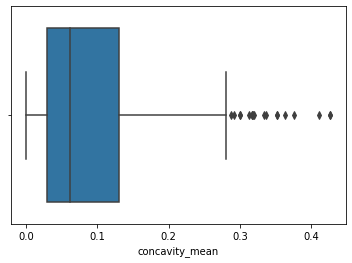

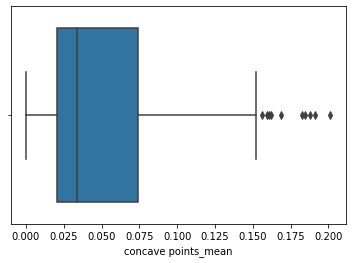

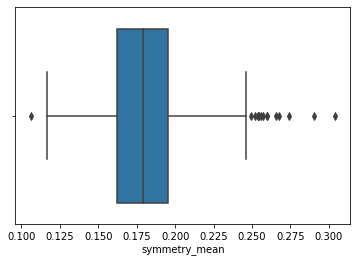

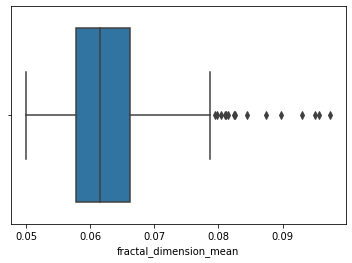

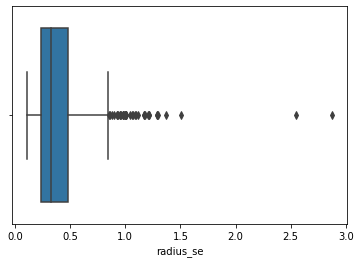

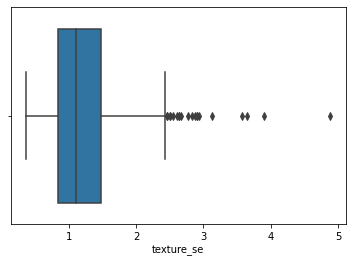

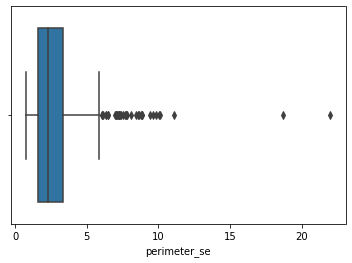

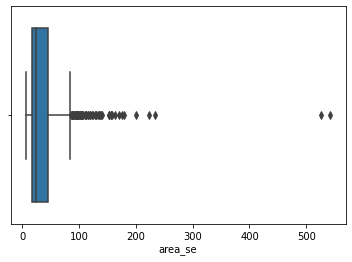

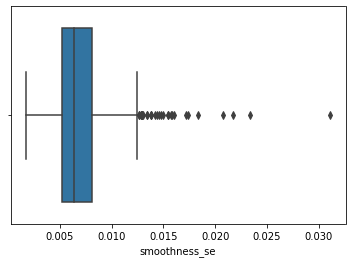

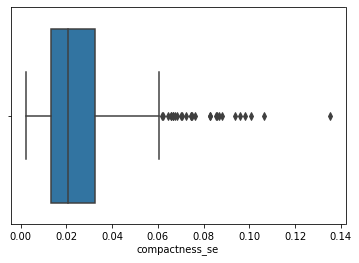

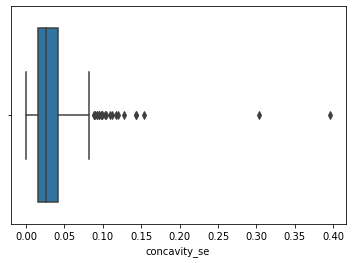

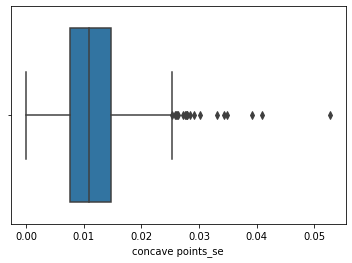

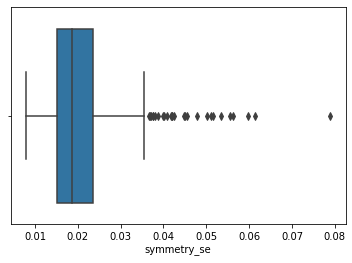

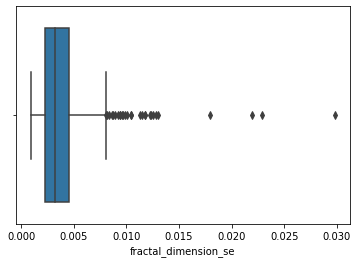

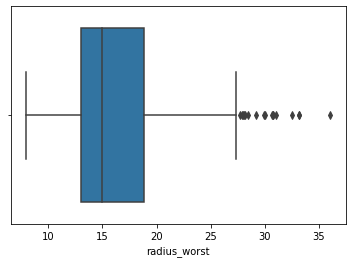

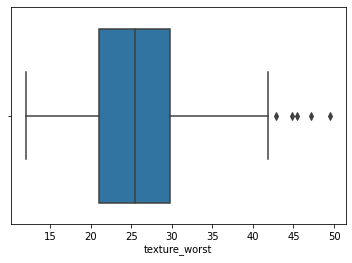

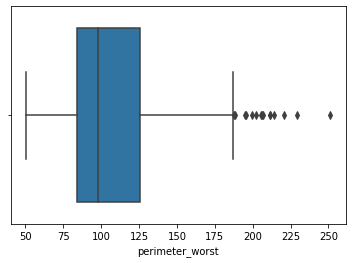

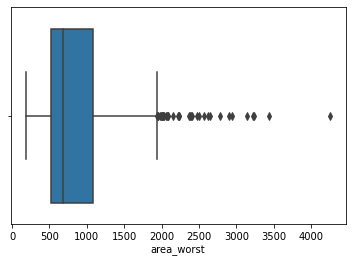

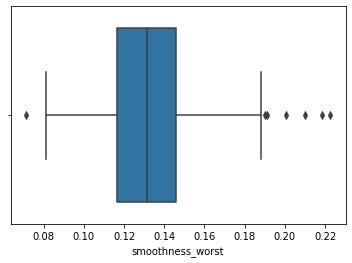

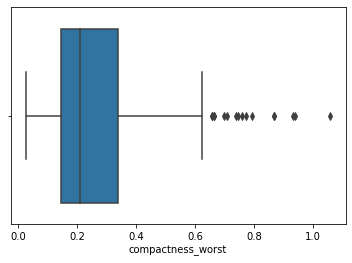

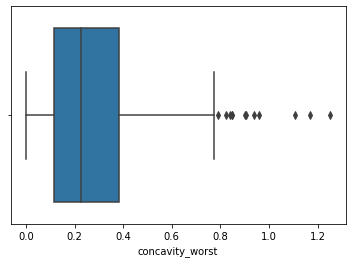

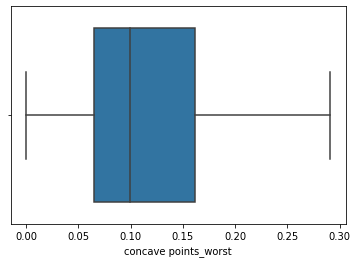

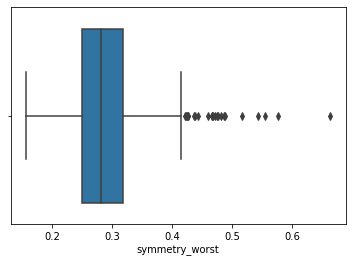

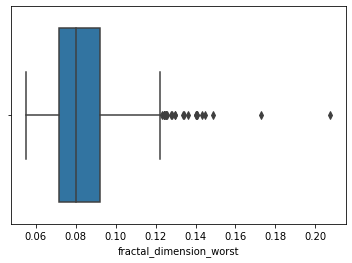

In [11]:
i = 0
for name in reg_no_label.columns:
  plt.figure()
  sns.boxplot(reg_no_label[name])

Pode-se ver acima que muitos valores agem como outliers nas distribuições. Para quase todos os casos os outliers são para cima. O código abaixo remove todas as instâncias fora de parâmetros razoáveis (baseado no seguinte código https://github.com/arshren/MachineLearning/blob/master/Identifying%20outliers.ipynb)

In [29]:
drops = []
for name in reg_no_label.columns:
  reg_sorted = sorted(reg_no_label[name])
  q1, q3= np.percentile(reg_sorted,[25,75])
  iqr = q3 - q1
  lower_bound = q1 -(1.5 * iqr) 
  upper_bound = q3 +(1.5 * iqr) 
  indexes = np.where((reg_no_label[name]>upper_bound)| (reg_no_label[name]<lower_bound))
  indexes
  drops = np.union1d(drops,indexes)
np.size(drops)

171

In [31]:
reg_no_outliers = reg_no_label.drop(drops)
reg_no_outliers.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
6,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.013820,0.02254,0.010390,0.01369,0.002179,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
7,13.71,20.83,90.2,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.030290,0.02488,0.014480,0.01486,0.005412,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
10,16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.51,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.19,33.88,123.8,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
11,15.78,17.89,103.6,781.0,0.09710,0.12920,0.09954,0.06606,0.1842,0.06082,0.5058,0.9849,3.564,54.16,0.005771,0.040610,0.02791,0.012820,0.02008,0.004144,20.42,27.28,136.5,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480
13,15.85,23.95,103.7,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,0.05338,0.4033,1.0780,2.903,36.58,0.009769,0.031260,0.05051,0.019920,0.02981,0.003002,16.84,27.66,112.0,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287


## PCA

Abaixo é aplicado o PCA ao conjunto de dados. Observe que segundo a documentação da função sklearn.decomposition.PCA, a centralização já é considerada automaticamente pela função

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.99)
reg_PCA = pca.fit_transform(reg_no_label)
pca.explained_variance_ratio_

array([0.98204467, 0.01617649])

Ou seja, com apenas duas PCs temos mais de 99% da variância de 29 features explicada !!!

Abaixo temos o scatterplot da decomposição em dois PCAs. De fato, não é muito compreensível hehe

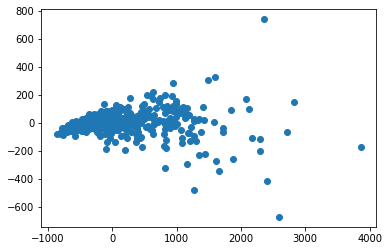

In [66]:
df = pd.DataFrame(reg_PCA)
plt.scatter(df[0], df[1])
plt.show()

In [70]:
reg_recovered = pca.inverse_transform(reg_PCA)

reg_recovered = pd.DataFrame(reg_recovered, columns = reg_no_label.columns)
reg_recovered.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.298417,22.684938,114.219815,1004.115558,0.105631,0.152147,0.161776,0.090729,0.196793,0.064494,0.784991,1.038938,5.219627,102.780887,0.005667,0.028138,0.033752,0.012849,0.015498,0.003611,24.736843,33.120002,164.693789,2021.859542,0.162406,0.447033,0.519744,0.209035,0.356998,0.102074
1,20.727501,22.032325,137.465955,1324.119334,0.101506,0.155731,0.193966,0.110283,0.189750,0.059219,0.802508,1.139681,5.717062,111.179078,0.006042,0.032682,0.043600,0.016104,0.019159,0.003691,25.340533,29.363530,170.026113,1953.832234,0.139315,0.378794,0.483837,0.207620,0.310337,0.085129
2,19.555781,21.364145,129.354839,1202.896386,0.099999,0.144591,0.173337,0.098314,0.187222,0.059556,0.715486,1.165670,5.125089,96.123963,0.006297,0.031473,0.041851,0.015428,0.019787,0.003721,23.371561,28.214221,156.503551,1708.711229,0.135752,0.345087,0.433536,0.186768,0.301750,0.083387
3,11.430511,18.589411,73.458639,387.051133,0.095634,0.088021,0.050372,0.026341,0.179981,0.064951,0.281052,1.219887,1.900236,17.139945,0.007268,0.022373,0.026348,0.009830,0.020221,0.003810,13.394237,25.318699,87.135539,568.659679,0.134933,0.230284,0.215227,0.086666,0.293369,0.087015
4,20.617641,20.787603,136.482756,1296.998985,0.097496,0.141535,0.179259,0.102148,0.182967,0.057307,0.686860,1.222250,5.101811,93.604519,0.006574,0.033024,0.045579,0.016619,0.021710,0.003770,22.817859,26.028733,153.238486,1574.884386,0.123789,0.299995,0.396126,0.177365,0.276993,0.074975


In [69]:
reg_no_label.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


A reconstrução aqui parece muito mais razoável. Vamos ver se o PCA tem melhor desempenho ao retirar os outliers de antemão

In [35]:

reg_no_outliers_PCA = pca.fit_transform(reg_no_outliers)
pca.explained_variance_ratio_

array([0.98671659, 0.01248644])

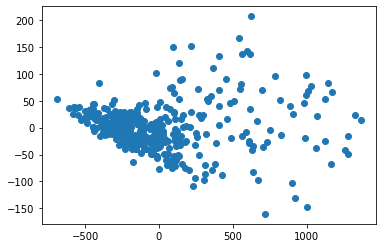

In [76]:
df = pd.DataFrame(reg_no_outliers_PCA)
plt.scatter(df[0], df[1])
plt.show()

In [36]:
reg_no_outliers_recovered = pca.inverse_transform(reg_no_outliers_PCA)

reg_no_outliers_recovered = pd.DataFrame(reg_no_outliers_recovered, columns = reg_no_outliers.columns)
reg_no_outliers_recovered.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,18.420843,22.500877,121.209855,1040.439691,0.103646,0.138617,0.158500,0.091818,0.188991,0.059934,0.584546,1.014127,3.971932,65.517519,0.005419,0.024111,0.033562,0.012764,0.013663,0.002952,23.427327,32.452437,155.335583,1604.983998,0.156929,0.396010,0.507694,0.207298,0.337975,0.092628
1,13.335080,19.822072,86.651929,577.659953,0.100316,0.103102,0.084608,0.048335,0.183121,0.063667,0.409058,1.121135,2.782492,37.356073,0.006475,0.020387,0.024943,0.009831,0.017366,0.003161,16.556381,28.247820,108.621388,898.015801,0.147607,0.286651,0.311208,0.129128,0.315857,0.090167
2,15.817590,20.416730,103.239220,797.771909,0.098173,0.111310,0.107480,0.062748,0.180908,0.060552,0.439367,1.054003,3.022743,45.202844,0.005919,0.021817,0.028618,0.011292,0.016249,0.002973,19.097977,28.403724,125.903796,1149.710630,0.142033,0.299524,0.354175,0.149472,0.306966,0.085689
3,15.506404,21.721760,101.704582,781.373509,0.105733,0.127944,0.130149,0.074123,0.191012,0.063444,0.542675,1.091246,3.651213,55.635255,0.006068,0.022389,0.029187,0.011052,0.015053,0.003162,20.351237,32.053953,134.419098,1298.886483,0.162322,0.376295,0.451236,0.181391,0.346176,0.097241
4,15.834786,18.328452,102.528123,782.320308,0.087099,0.084576,0.068909,0.042853,0.165989,0.056736,0.277126,1.009815,2.025529,27.942505,0.005794,0.020687,0.027082,0.011390,0.018268,0.002719,16.731552,22.838854,109.822594,877.346425,0.112281,0.180728,0.199091,0.097333,0.249125,0.068987


In [37]:
reg_no_outliers.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
6,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,0.4467,0.7732,3.180,53.91,0.004314,0.013820,0.02254,0.010390,0.01369,0.002179,22.88,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368
7,13.71,20.83,90.2,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,0.5835,1.3770,3.856,50.96,0.008805,0.030290,0.02488,0.014480,0.01486,0.005412,17.06,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510
10,16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,0.3795,1.1870,2.466,40.51,0.004029,0.009269,0.01101,0.007591,0.01460,0.003042,19.19,33.88,123.8,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452
11,15.78,17.89,103.6,781.0,0.09710,0.12920,0.09954,0.06606,0.1842,0.06082,0.5058,0.9849,3.564,54.16,0.005771,0.040610,0.02791,0.012820,0.02008,0.004144,20.42,27.28,136.5,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480
13,15.85,23.95,103.7,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,0.05338,0.4033,1.0780,2.903,36.58,0.009769,0.031260,0.05051,0.019920,0.02981,0.003002,16.84,27.66,112.0,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287


Os valores aqui estão muito mais próximos. Observe por exemplo a coluna texture_mean que, vemos que os valores das 5 primeiras instâncias estão muito mais próximos dos valores equivalentes pré-PCA (a maior diferença é de cerca de 5 pontos), enquanto no caso anterior a maior diferença foi de cerca de 12 pontos. Olhando os outros parâmetros, vê-se que os resultados pós processamento por PCA são muito bons.

## Regressão linear

Regressão linear não faz sentido nesse dataset, pois trata-se de um claro caso de classificação (ou o tumor é benigno ou maligno). Logo, a sessão de regressão logísitca e Clustering será dedicada ao mesmo

# 3 - Regressão Logística e Clustering

Começamos com uma regressão logística. Sua característica de classificar binariamente dados nos vai parmitir ter um parâmetro mínimo de qualidade. Na sequência, performamos kmeans e dbscan. A vantagem do clustering no nosso caso é óbvia: sabemos quantos clusters existem, 2. Isso porque, como descrito antes, o diagnóstico só pode ser câncer maligno ou benigno

In [85]:
X_train, X_test, y_train, y_test = train_test_split(reg_no_label, reg['diagnosis'], test_size = 0.2)


In [83]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [86]:
log_reg.score(X_test,y_test)

0.956140350877193

O score gira em torno de 96%!! Ou seja, uma simples Regressão logística já é capaz de dar certeza em quase 96% de certeza. No entanto, não queremos dar um diagnóstico errado para os pacientes, pois uma notícia como essa pode ser grave. Observe, no entanto, que a regressão logística não convergiu. Vejamos se fazer algo do tipo em cima do PCA  nos traz convergência




In [99]:
X_train, X_test, y_train, y_test = train_test_split(reg_PCA, reg['diagnosis'], test_size = 0.2)
log_reg.fit(X_train, y_train)
log_reg.score(X_test,y_test)

0.9210526315789473

Com PCA, não temos mais a mensagem de não convergência, mas nosso score abaixa na média de 3 a 5 pontos. No entanto, é bom o suficiente para nossa clusterização na sequência. A vantagem do PCA com suas duas componentes é que podemos ver a regressão logística em um gráfico

 Abaixo temos o scatterplot das duas grandes regiões. Percebe-se que quanto menos a primeira componente principal, maior a chance do tumor ser benigno, assim como para valores um pouco maiores da segunda componente principal, para uma mesma primeira, aumenta-se a chance do tumor ser benigno

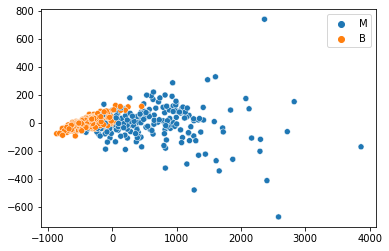

In [104]:
sns.scatterplot(x = reg_PCA[:,0], y = reg_PCA[:,1], hue = reg['diagnosis'].values, data = reg_PCA)

## KMEANS

In [121]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
y = kmeans.fit_predict(reg_PCA)

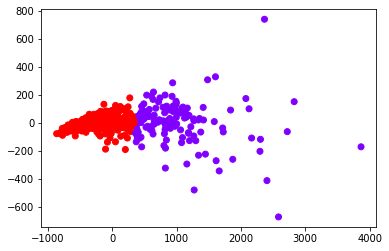

In [122]:
plt.scatter(reg_PCA[:,0],reg_PCA[:,1], c=kmeans.labels_, cmap='rainbow')


Comparando os dois últimos scatterplots vemos que kmeans consegue separar bem os caso benignos dos malignos com na direção do eixo X (vê-se uma clara divisão em torno de X=300), porém, como salientado anteriormente, entre -100 e 300 mais ou menos, os casos benignos e malignos se diferencial pela variação no eixo Y. Abaixo calculo a correlação entre kmeans.labels_ e reg['diagnosis']

In [127]:
label = LabelEncoder()
int_data = label.fit_transform(reg['diagnosis'])
np.corrcoef(int_data, kmeans.labels_)

array([[ 1.        , -0.70104909],
       [-0.70104909,  1.        ]])

Correlação de apenas 70%. De fato, o modelo do kmeans não é tão bom. Podemos ver abaixo o tanto de vezes que o modelo acertou, usando o operado ^(ou exclusivo). Como o LabelEncoder codou M como 0 e B como 1 (enquanto kmeans fez o inverso, os valores só vão bater nos dois quando a função xor der 1 (ou seja, os valores de kmeans.labels_ e int_data forem trocados). Somando todos os 1's e dividindo pelo número de instâncias temos a taxa de acerto de cerca de 85%

In [133]:
sum(int_data^kmeans.labels_)/len(int_data)

0.8541300527240774

## DBSCAN

Vamos testar agora testado o DBSCAN. No caso, aparentemente DBSCAN não se pode especificar o número de clusters, ao menos não parece pela documentação oficial em https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html (embora pareça que recentemente há pessoas que adicionaram essa funcionalidade ao HDBSCAN https://stackoverflow.com/questions/48269092/hdbscan-python-choose-number-of-clusters), o que é problemático, pois é preciso de apenas dois. Segue que rodar o DBSCAN abaixo vai servir apenas como curiosidade

In [139]:
from sklearn.cluster import DBSCAN

dbs = DBSCAN(eps = 0.5, min_samples = 100)

dbs.fit(reg_PCA)

dbs.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

Veja que o resultado acima se repetiu para diferentes valores de eps e min_samples. Segue que esse algoritmo simplesmente não é apropriado para nosso caso de classificação.